## Long Short Term Memory Recurrent Neural Networks  

### Using Long Short Term Memory Recurrent Neural Networks to label posts in test set

Having gathered the posts by scraping, a sample of 1000 posts were labelled manually so as to train models to subsequently predict labels on the remainder of the dataset (around 9000 posts). *Textblob and VADER (unsupervised learning text classification models) were initially used to predict the sentiment of the posts, but the results were not accurate*

The labels are: 
- **0 for negative sentiment** 
- **1 for neutral sentiment**
- **2 for positive sentiment**

It should be noted that the labels were highly skewed, with around 80% of the posts classed as neutral, 15% as negative and 5% positive. This affected how well the model was able to predict the sentiment of unlabelled posts. 

The models chosen were classification models - Logistic Regression and Multinomial Naive Bayes, Long Short Term Memory Recurrent Neural Net model and BERT. 

Link to google collab notebook for BERT model: https://colab.research.google.com/drive/14-Yo8eGbbyCpOGRyszqK1iJIjCFybNnu?usp=sharing

It was found that the Multinomial Naive Bayes model was the most accurate in predicting sentiment. It had high Accuracy, ROC AUC and F1 scores, with little variance between the train and validation sets, as well as being more likely to assign minority classes, compared to the Logistic Regression Model. The performance of LSTM RNN and BERT models paled in comparison as well. For BERT, it could be that the pretrained model did not generalise well on the dataset, due to the nature of the local Singlish language (in terms of different words and sentence structures). The LSTM RNN model also did not do well, as it relied on learning words before and after a significant word, instead of standalone words, which did not work particularly well for this dataset.  

It should be noted that methods such as SMOTE, random oversampling and manipulating class weights were used to try to address the issue of unbalanced classes in the data, all of which did not perform as well as a model where the minority classes were not oversampled/given more weightage in the model. 

The process of assessing a production model for sentiment analysis is as follows:
1. **Train Multinomial NB model on all posts in train set, which have labelled sentiments (THIS NOTEBOOK)** 
2. **Predict label on posts in test set (THIS NOTEBOOK)** 
3. Check accuracy of predictions and make changes to incorrect labels 
4. Collate labelled posts in train and test sets to train final production model 

While I acknowledge that it is not ideal to use a regular supervised learning classification models to predict the sentiment of text posts, this was the best method for this particular dataset. I believe that with more data gathered, a LSTM RNN or BERT model can be sufficiently trained to better predict sentiment of posts from Singaporean forums.  

---
## Importing libraries and collating labelled posts in train set 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE, RandomOverSampler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam



from sklearn import metrics

In [2]:
#import labelled posts 

first_2000 = pd.read_csv('./labelled_posts/train_2000_labelled.csv')
first_2000.head()

,post,manual label,date,source,post_clean
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh


In [3]:
first_2000.rename(columns = {'manual label': 'label'}, inplace=True)
first_2000.head(2)

,post,label,date,source,post_clean
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,consistency accuracy could easier use data new...


In [4]:
post_2000_2999 = pd.read_csv('./labelled_posts/2000_2999_labelled_checked.csv')
post_2000_2999.head()

,Unnamed: 0,post,label,date,source,post_clean
0,0,Normal day to day probably but we're talking a...,1.0,2020-04-09 22:12:56,reddit,normal day day probably talking food provided ...
1,1,Maybe they are not the main reason. But it's s...,1.0,2020-05-08 09:27:47,reddit,maybe not main reason still big reason
2,2,Quite f up but there's really nothing much nor...,1.0,2020-06-04 23:53:00,hardwarezone,quite f really nothing much normal citizens li...
3,3,Not everyone. Only Singapore Citizens and PR.\...,1.0,2020-04-05 02:31:02,reddit,not everyone singapore citizens pr cna officia...
4,4,"Maybe too many liao, tmr might be a big spike ...",0.0,2020-05-04 19:34:00,hardwarezone,maybe many tmr might big spike number no point...


In [5]:
post_2000_2999.drop(columns = ['Unnamed: 0'], inplace=True)
post_2000_2999.head(2)

,post,label,date,source,post_clean
0,Normal day to day probably but we're talking a...,1.0,2020-04-09 22:12:56,reddit,normal day day probably talking food provided ...
1,Maybe they are not the main reason. But it's s...,1.0,2020-05-08 09:27:47,reddit,maybe not main reason still big reason


In [6]:
post_3000_3999 = pd.read_csv('./labelled_posts/3000_3999_labelled_checked.csv')
post_3000_3999.head()

,Unnamed: 0,post,checked,date,source,post_clean,labels
0,0,lets shoot to the moon.,1.0,2020-04-14 20:22:00,hardwarezone,lets shoot moon,1.0
1,1,The dorm operators are there for profit. They ...,1.0,2020-04-06 21:58:35,reddit,operators profit stick many men room law allow...,1.0
2,2,"Is not talent as an excuse, loyalty is the utm...",0.0,2020-06-06 14:14:00,sgtalk,not talent excuse loyalty utmost important no ...,1.0
3,3,smlj also set up task forcelike that means no ...,0.0,2020-09-04 20:36:00,hardwarezone,smlj also set task forcelike means no individu...,1.0
4,4,We're now at the endgame guys.,1.0,2020-04-10 01:45:46,reddit,endgame guys,1.0


In [7]:
post_3000_3999.drop(columns = ['Unnamed: 0', 'labels'], inplace=True)
post_3000_3999.rename(columns = {'checked': 'label'}, inplace=True)
post_3000_3999.head(2)

,post,label,date,source,post_clean
0,lets shoot to the moon.,1.0,2020-04-14 20:22:00,hardwarezone,lets shoot moon
1,The dorm operators are there for profit. They ...,1.0,2020-04-06 21:58:35,reddit,operators profit stick many men room law allow...


In [8]:
post_4000_4999 = pd.read_csv('./labelled_posts/4000_4999_labelled_checked.csv')
post_4000_4999.head()

,post,manual label,date,source,post_clean
0,They will sneak peenoise maids in and orgy?,1,2020-01-05 06:42:00,hardwarezone,sneak peenoise maids orgy
1,"True that pests like cockroaches, rats and mos...",1,2020-05-08 12:05:32,reddit,true pests like cockroaches rats mosquitoes kn...
2,even more than Malaysia.New Record :O,1,2020-09-04 20:49:00,hardwarezone,even malaysia new record
3,"""none infected by foreign workers in dorms""so....",1,2020-04-23 12:35:00,hardwarezone,none infected outside
4,Perhaps it's time to make dorm operators liabl...,1,2020-04-07 00:13:59,reddit,perhaps time make operators liable least porti...


In [9]:
post_4000_4999.rename(columns = {'manual label': 'label'}, inplace=True)
post_4000_4999.head(2)

,post,label,date,source,post_clean
0,They will sneak peenoise maids in and orgy?,1,2020-01-05 06:42:00,hardwarezone,sneak peenoise maids orgy
1,"True that pests like cockroaches, rats and mos...",1,2020-05-08 12:05:32,reddit,true pests like cockroaches rats mosquitoes kn...


In [10]:
post_5000_5999 = pd.read_csv('./labelled_posts/5000_5999_labelled_checked.csv')
post_5000_5999.head()

,post,manual label,date,source,post_clean
0,"To be powerful and rich, you have to be part o...",1,2020-12-04 01:42:00,hardwarezone,powerful rich part pa deals relationships
1,Die alrdyThis ish like the new Normal...,1,2020-04-14 19:20:00,hardwarezone,die alrdythis ish like new normal
2,feel very sad for all the Bangla...they come h...,1,2020-06-04 22:17:00,hardwarezone,feel sad bangla come honest living get treated...
3,"how comes so long still no MOH release, only g...",1,2020-05-04 22:07:00,hardwarezone,comes long still no moh release got numberswai...
4,"They aren't testing everyone. They are ""active...",1,2020-04-20 15:44:38,reddit,testing everyone actively testing not really t...


In [11]:
post_5000_5999.rename(columns = {'manual label': 'label'}, inplace=True)
post_5000_5999.head(2)

,post,label,date,source,post_clean
0,"To be powerful and rich, you have to be part o...",1,2020-12-04 01:42:00,hardwarezone,powerful rich part pa deals relationships
1,Die alrdyThis ish like the new Normal...,1,2020-04-14 19:20:00,hardwarezone,die alrdythis ish like new normal


In [12]:
post_6000_8214 = pd.read_csv('./labelled_posts/6000_8214_labelled_checked.csv')
post_6000_8214.head()

,Unnamed: 0,post,preds,manual label,date,source,post_clean,Unnamed: 7
0,20,"If sick people wore masks or, more importantly...",0.0,0,2020-04-11 11:12:29,reddit,sick people wore masks importantly isolated wo...,NaN
1,23,MOM is the CB KiaNot i say one is this biz own...,0.0,0,2020-04-23 17:58:00,hardwarezone,mom cb kianot say one biz owner say oneclearly...,NaN
2,30,Then late Jan should give us cloth mask instea...,0.0,1,2020-04-14 19:52:00,hardwarezone,late jan should give us cloth mask instead say...,NaN
3,92,Can't wait for pap and their ibs to implode on...,0.0,0,2020-04-18 14:08:00,hardwarezone,wait pap ibs implode,NaN
4,107,Errrrrrrrrr..pap wansui,0.0,1,2020-04-23 15:32:00,hardwarezone,errrrrrrrrr pap wansui,NaN


In [13]:
post_6000_8214.drop(columns = ['Unnamed: 0', 'preds', 'Unnamed: 7'], inplace=True)
post_6000_8214.rename(columns = {'manual label': 'label'}, inplace=True)
post_6000_8214.head(2)

,post,label,date,source,post_clean
0,"If sick people wore masks or, more importantly...",0,2020-04-11 11:12:29,reddit,sick people wore masks importantly isolated wo...
1,MOM is the CB KiaNot i say one is this biz own...,0,2020-04-23 17:58:00,hardwarezone,mom cb kianot say one biz owner say oneclearly...


In [14]:
# concat all labelled posts into 1 dataframe

train = pd.concat([first_2000, post_2000_2999, post_3000_3999, post_4000_4999, post_5000_5999, post_6000_8214]
                  , ignore_index = True)
train.drop(columns = ['post_clean'], inplace=True)   #post will be re-preprocessed, leaving in stopwords
print(train.shape)
train.head()

(8213, 4)


,post,label,date,source
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone


In [15]:
#find null values 
train.isnull().sum()

post      3
label     1
date      0
source    0
dtype: int64

In [16]:
#fill row with label = null as 0 
train[train['label'].isnull()]
train['label'].fillna(0, inplace=True)

In [17]:
train.isnull().sum()
train.fillna('nopost', inplace=True)

---
## Preprocessing of posts in train data for RNN modeling 

For posts: 
- Tokenising
- Lemmatising
- Vectorising
- Truncate/pad 

For labels:
- One hot encode labels 

In [18]:
# function for preprocessing posts in train
# will not remove stop words to help with sequentiality 

def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
 
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
    
    #return words as a single string 
    return(' '.join(lem))

In [19]:
post_clean_for_rnn = []

for p in train["post"]:
    post_clean_for_rnn.append(preprocess(p))

print(f"checking post_clean_for_rnn: \n{post_clean_for_rnn[1:3]}")

train['post_clean_for_rnn'] = post_clean_for_rnn
train.head(10)

checking post_clean_for_rnn: 
['for consistency and accuracy it could be easier to use data from the new moh situation report which separate into dorm non dorm foreigner and citizen pr i think they only count those from the named dorm cluster into dorm so those who are either linked to construction site or who live in non cluster dorm get categorized a linked to other cluster or pending investigation respectively so the moh situation report for 28 3 to 10 4 ltp holder ha 545 linked to dorm cluster 126 linked to other cluster and 141 pending investigation whereas my estimate for the same time period is 702 dorm construction related the reason i make these graph is that there are really 2 separate covid problem in singapore circuit breaker can slow down the growth of the case in the general public but other than stopping work at construction site circuit breaker doesn t help the dorm construction site problem the dorm construction site problem ha to be tackled by improving the living con

,post,label,date,source,post_clean_for_rnn
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao
5,I’m not saying we caused this spread among the...,0.0,2020-04-16 23:59:35,reddit,i m not saying we caused this spread among the...
6,1. From healthy no wear mask to Mask mandatory...,0.0,2020-04-14 20:29:00,hardwarezone,1 from healthy no wear mask to mask mandatory ...
7,Exactly. People don’t even wanna let our publi...,2.0,2020-05-27 20:28:30,reddit,exactly people don t even wanna let our public...
8,The current situation is beyond this woman. 24...,1.0,2020-06-06 14:40:00,sgtalk,the current situation is beyond this woman 24h...
9,"Iran, followed by China, India, Israel, Saudi ...",0.0,2020-04-23 17:52:00,hardwarezone,iran followed by china india israel saudi arab...


In [20]:
#saving cleaned train posts 

train.to_csv('./labelled_posts/train_labelled_clean.csv')

In [22]:
#Vectorize post text, by turning each text into either a sequence of integers or into a vector

# The maximum number of words to be used. (most frequent)
max_nb_words = 50000

# Max number of words in each complaint.
max_seq_length = 512

# This is fixed.
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['post_clean_for_rnn'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15809 unique tokens.


In [23]:
#truncate and pad 
X = tokenizer.texts_to_sequences(train['post_clean_for_rnn'].values)
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8213, 512)


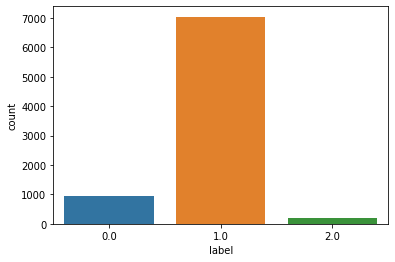

In [21]:
#classes v unbalanced
ax = sns.countplot(train['label'])

In [24]:
#one hot encoding labels 
y = pd.get_dummies(train['label']).values
y.shape

(8213, 3)

---
## RNN modeling 

As stated earlier, I had tried methods of oversample the minority classes (0 and 2) with SMOTE and RandomOverSampler, and manipulating class weights when fitting the model. All of these methods did not perform as well as the RNN model without oversampling. 


In [25]:
#random oversampling to boost minority classes 0 and 2 
# oversample = RandomOverSampler()
# X_over, y_over = oversample.fit_resample(X, y)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, 
                                                 stratify = y, random_state = 42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(6570, 512) (6570, 3)
(1643, 512) (1643, 3)


In [27]:
# #SMOTE to oversample minority classes 
# sm = SMOTE()
# X_train, y_train = sm.fit_resample(X_train, y_train)

In [28]:
# Scale
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [29]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 512, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

In [30]:
epochs = 20
batch_size = 32

# class_weight = {0: 5,
#                 1: 1,
#                2: 10}

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data = (X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
#                     class_weight = class_weight,
                   verbose=1)

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
206/206 [==============================] - 283s 1s/step - loss: 0.5247 - auc: 0.9134 - val_loss: 0.4781 - val_auc: 0.9145
Epoch 2/20
206/206 [==============================] - 283s 1s/step - loss: 0.4997 - auc: 0.9141 - val_loss: 0.4793 - val_auc: 0.9173
Epoch 3/20
206/206 [==============================] - 338s 2s/step - loss: 0.4985 - auc: 0.9122 - val_loss: 0.4808 - val_auc: 0.9157
Epoch 4/20
206/206 [==============================] - 284s 1s/step - loss: 0.4899 - auc: 0.9170 - val_loss: 0.4791 - val_auc: 0.9170


### Evaluating performance of RNN model 

52/52 [==============================] - 7s 140ms/step - loss: 0.4791 - auc: 0.9170
Test set
  Loss: 0.479
  Accuracy: 0.917


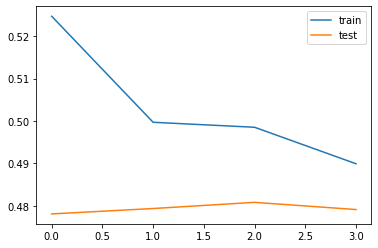

In [31]:
acc = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Fit model with entire train data to predict unlabelled posts in test data

In [32]:
#fit X and y to model to predict other unlabelled posts 

model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1)

Epoch 1/10
257/257 [==============================] - 348s 1s/step - loss: 0.4806 - auc: 0.9254
Epoch 2/10
257/257 [==============================] - 331s 1s/step - loss: 0.3633 - auc: 0.9632
Epoch 3/10
257/257 [==============================] - 283s 1s/step - loss: 0.2735 - auc: 0.9793
Epoch 4/10
257/257 [==============================] - 297s 1s/step - loss: 0.2050 - auc: 0.9884
Epoch 5/10
257/257 [==============================] - 304s 1s/step - loss: 0.1625 - auc: 0.9925
Epoch 6/10
257/257 [==============================] - 280s 1s/step - loss: 0.1295 - auc: 0.9949
Epoch 7/10
257/257 [==============================] - 280s 1s/step - loss: 0.1004 - auc: 0.9967
Epoch 8/10
257/257 [==============================] - 264s 1s/step - loss: 0.0812 - auc: 0.9976
Epoch 9/10
257/257 [==============================] - 256s 994ms/step - loss: 0.0666 - auc: 0.9985
Epoch 10/10
257/257 [==============================] - 254s 987ms/step - loss: 0.0522 - auc: 0.9988


---
## Predicting labels on posts in test data based on RNN model 

In [34]:
#import test data to predict sentiment 

test = pd.read_csv('./unlabelled_posts/test_posts.csv')
test.head()

,post,date,source,post_clean
0,Need more camp to house all foreign worker,2020-04-15 15:09:00,hardwarezone,need camp house
1,Im interested in the clusters esp new ones. Wh...,2020-04-29 23:07:00,hardwarezone,im interested clusters esp new ones see
2,did the virus make his kkj buay kia?,2020-04-23 21:22:00,hardwarezone,make kkj buay kia
3,I’m not saying there isn’t room for improvemen...,2020-04-08 11:23:23,reddit,not saying room improvement point choice nsfs ...
4,abnn good life no need work get paid and free ...,2020-04-05 13:04:00,hardwarezone,abnn good life no need work get paid free food...


In [35]:
test.isnull().sum()
test['post'].fillna('nopost', inplace=True)

In [36]:
test_posts = test['post']

In [37]:
#predict sentiment class of post in unlabelled set (3000-3999)
posts_to_pred = []

for post in test_posts:
    seq = tokenizer.texts_to_sequences(post)
    padded = pad_sequences(seq, maxlen=max_seq_length)
    posts_to_pred.append(padded)
    

In [38]:
print(len(posts_to_pred))
posts_to_pred[1]

2055


array([[  0,   0,   0, ...,   0,   0,  13],
       [  0,   0,   0, ...,   0,   0, 193],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0, 681],
       [  0,   0,   0, ...,   0,   0, 681],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [39]:
preds = []

for i in range(len(posts_to_pred)):
    pred = model.predict_classes(posts_to_pred[i], verbose = 1)
    preds.append(pred.sum()/len(pred))
    

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
24/24 [==============================] - 4s 165ms/step


17/17 [==============================] - 3s 156ms/step


3/3 [==============================] - 0s 149ms/step


9/9 [==============================] - 2s 272ms/step


2/2 [==============================] - 0s 94ms/step


3/3 [==============================] - 1s 184ms/step


1/1 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 79ms/step


In [40]:
print(len(preds))
preds[1]

2055


1.0

In [41]:
test['predictions'] = preds 
test.head()

,post,date,source,post_clean,predictions
0,Need more camp to house all foreign worker,2020-04-15 15:09:00,hardwarezone,need camp house,1.0
1,Im interested in the clusters esp new ones. Wh...,2020-04-29 23:07:00,hardwarezone,im interested clusters esp new ones see,1.0
2,did the virus make his kkj buay kia?,2020-04-23 21:22:00,hardwarezone,make kkj buay kia,1.0
3,I’m not saying there isn’t room for improvemen...,2020-04-08 11:23:23,reddit,not saying room improvement point choice nsfs ...,1.0
4,abnn good life no need work get paid and free ...,2020-04-05 13:04:00,hardwarezone,abnn good life no need work get paid free food...,1.0


In [42]:
test.to_csv('./labelled_posts/test_rnn_labelled.csv')